In [3]:
# we will import all the necessary libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import json
import re
from shapely.geometry import Point, LineString #this library is for manipulating geometric objects, and it is what geopandas uses to store geometries
from scipy.spatial import distance
from operator import itemgetter
# !pip install openpyxl
import openpyxl

### Load London Underground shapefile data

In [128]:
#read in the data using geopandas
stations = gpd.read_file('data/tfl_stations.json')
lines = gpd.read_file('data/tfl_lines.json')

In [129]:
#project data to British National Grid
#we do this so we can work in meters
stations = stations.to_crs(epsg = 27700)
lines = lines.to_crs(epsg = 27700)

### Clean station names

We have multiple points representing one station (for example Paddington has seperate points for different entrances). We will simplify this by using RegEx make the names consistent. 

Once we have cleaned the names we can set the coordinate of these stations to the mean values of the coordinates of all the stations with the same name.

In [131]:
#get all station names
station_names = {row.id: row['name'] for i, row in stations.iterrows()}
#creates a dictionary station_names where the keys are the 'id' column values from the stations dataframe
#and the values are the corresponding 'name' column values.
#for i, row in stations.iterrows(): This iterates over each row of the stations dataframe
#The iterrows() method yields an index i and a row object for each row in the dataframe.

In [197]:
#clean station names
for k, v in station_names.items():
    if k == 'none':
        continue
    cleaned_name = re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', v)
    
    #note that bank and monument are enconded as one station in our TFL data, so we will do the same
    if cleaned_name in ['Bank', 'Monument']:
        cleaned_name = 'Bank and Monument'
    station_names[k] = cleaned_name
    
stations['name'] = stations['id'].apply(lambda x: station_names[x])
#applies a lambda function to each value in the 'id' column of the stations dataframe.
#for each ID x, it retrieves the corresponding cleaned station name from the station_names
#dictionary and assigns it to the 'name' column of the stations dataframe.

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
C:\Users\shaun\AppData\Local\Temp\ipykernel_3424\533110036.py:5: SyntaxWarning: invalid escape sequence '\s'
  cleaned_name = re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', v)


**Change position of station to mean of all station with the same name**

In [198]:
#get position of stations as mean of x, y of stations

#create empty dict to store list of coordinates
pos = {}

#iterate through the stations
for i, station in stations.iterrows():
    xy = station.geometry.coords[0]
    
    #if station already in dict add coordinate to coordinate list
    if station['name'] in pos.keys():
        pos[station['name']].extend([xy])
    #if station is not in the dict add station to dict and set first coordinate in list
    else:
        pos[station['name']] = [xy]

#iterate through our dict and replace coordinate list with mean value
for k, v in pos.items():
    #we set axis to 0 to make sure to take mean of x and y coordinates
    pos[k] = np.mean(v, axis=0)

In [134]:
#set new geometry
stations['geometry'] = stations['name'].apply(lambda x: Point(pos[x]))

### Lines file

### Get all line names

We can see from our lines geodataframe that one geometry can represent multiple lines. Let's work each line seperately to make cleaning and checking the data easier. 

In [142]:
#get all line types as a list and subset geoms by lines
line_names  = lines.lines.apply(lambda x: [x['name'] for x in json.loads(x)] )
line_names = list(set([item for sublist in line_names for item in sublist]))
line_names

['Victoria',
 'Jubilee',
 'Elizabeth',
 'London Overground',
 'Piccadilly',
 'Central',
 'Bakerloo',
 'Circle',
 'Metropolitan',
 'Tramlink',
 'CR2',
 'District',
 'Hammersmith & City',
 'Thameslink 6tph line',
 'Emirates Air Line',
 'Waterloo & City',
 'Northern',
 'DLR']

In [141]:
#We can see that east london line is incomplete
#digging into this however we notice that it's because east london is actually part of the overground
#merge East London line and London Overground since they are one line
lines.lines = lines.lines.str.replace('East London', 'London Overground')
stations.lines = stations.lines.str.replace('East London', 'London Overground')

# Change Crossrail to Elizabeth, exact match replacement
lines.lines = lines.lines.str.replace('Crossrail', 'Elizabeth')
stations.lines = stations.lines.str.replace('Crossrail', 'Elizabeth')

# Change TfL Rail to Elizabeth, exact match replacement
lines.lines = lines.lines.str.replace('TfL Rail', 'Elizabeth')
stations.lines = stations.lines.str.replace('TfL Rail', 'Elizabeth')

# Change TfL Rail to Elizabeth, exact match replacement
lines.lines = lines.lines.str.replace('Elizabeth 2', 'CR2')
stations.lines = stations.lines.str.replace('Elizabeth 2', 'CR2')


In [143]:
#Our TFL data doesn't include tramlink, emirates air lines, and crossrail is still in construction (except not really)
#exclude the lines that we are not going to use
excluded_lines = ['Thameslink 6tph line', 'East London', 'CR2', 'Emirates Air Line', 'Tramlink', 'TfL Rail']

Victoria


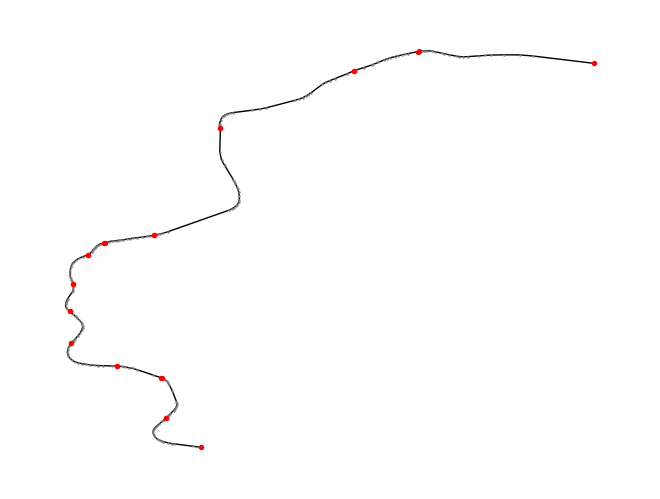

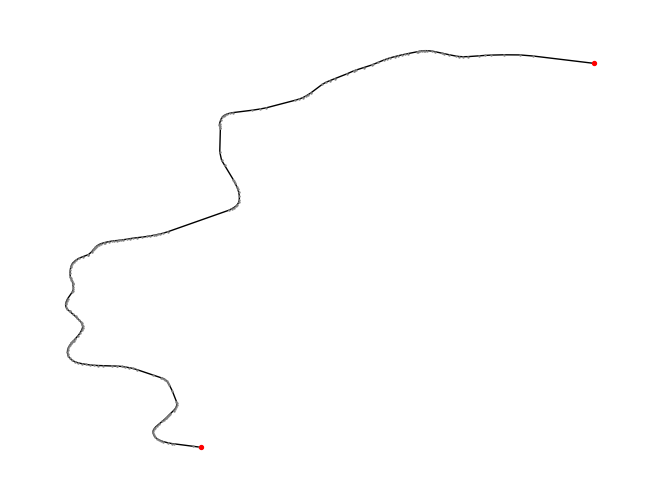

1
Jubilee


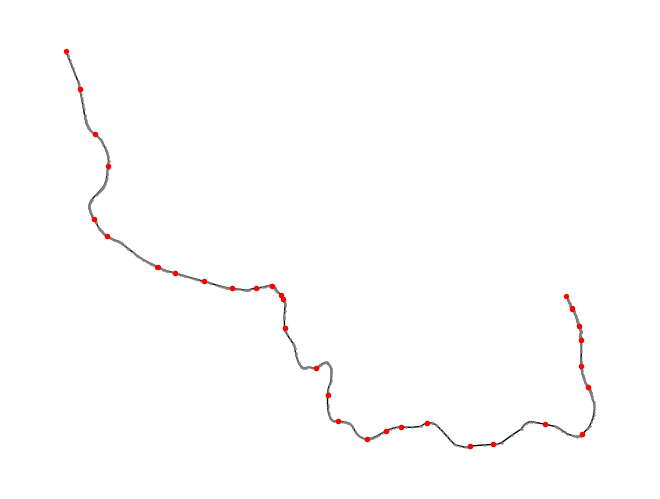

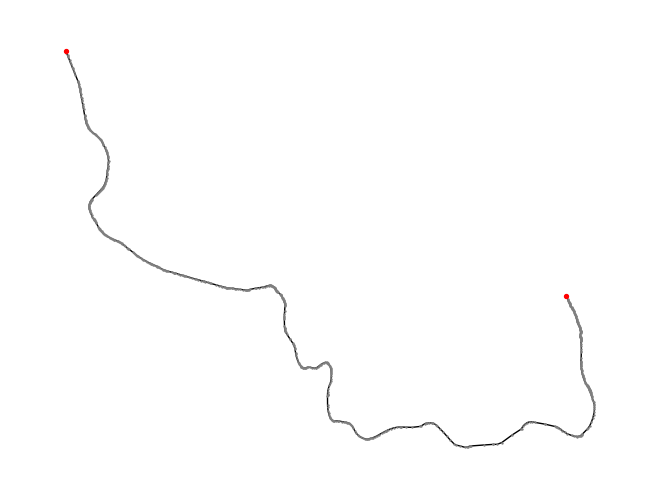

1
Elizabeth


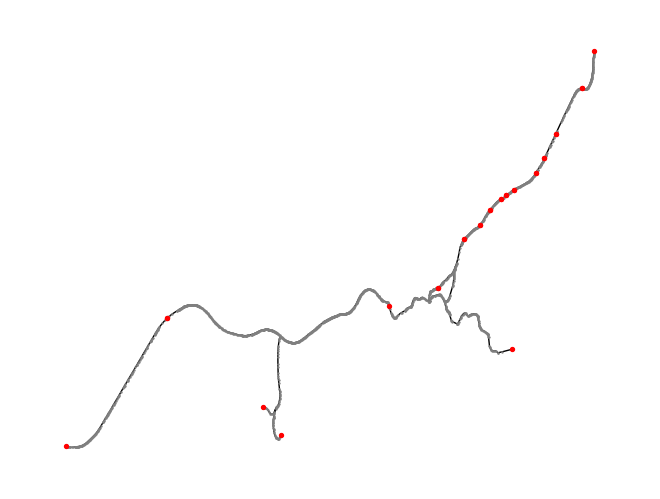

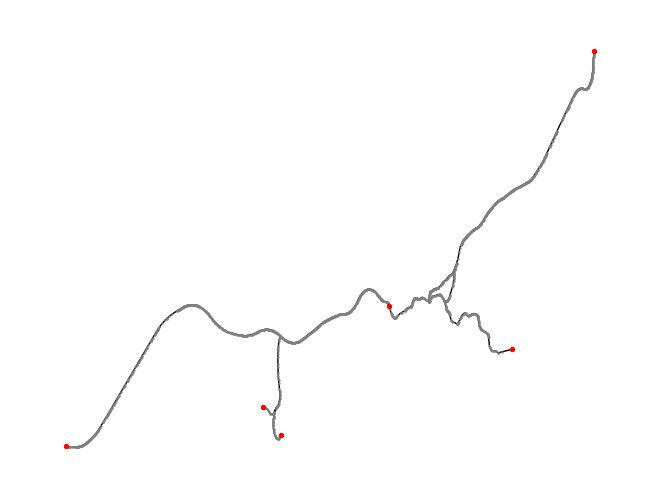

1
London Overground


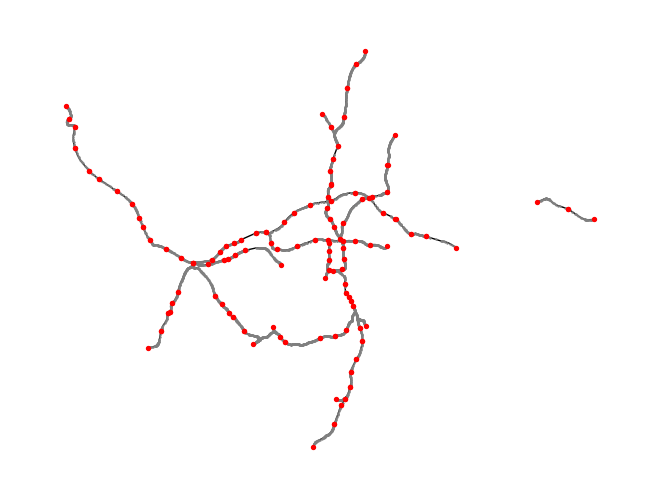

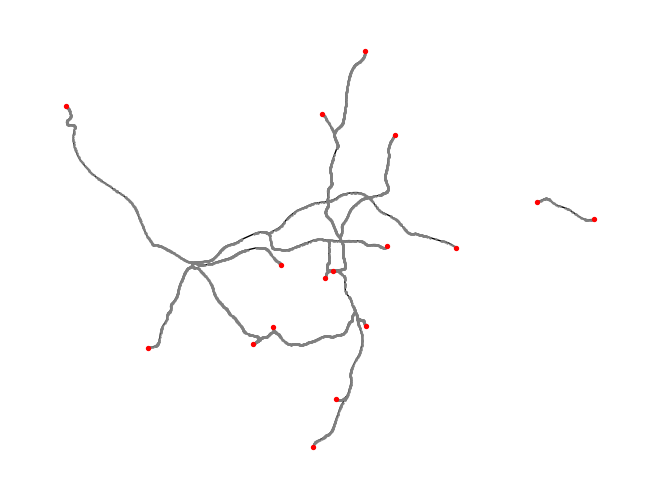

3
Piccadilly


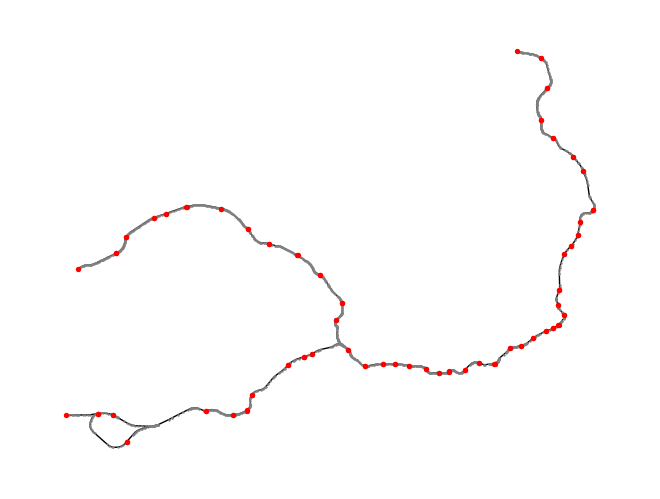

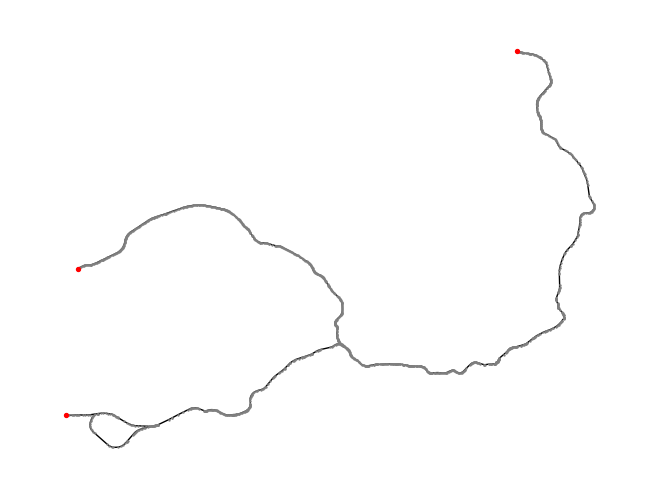

1
Central


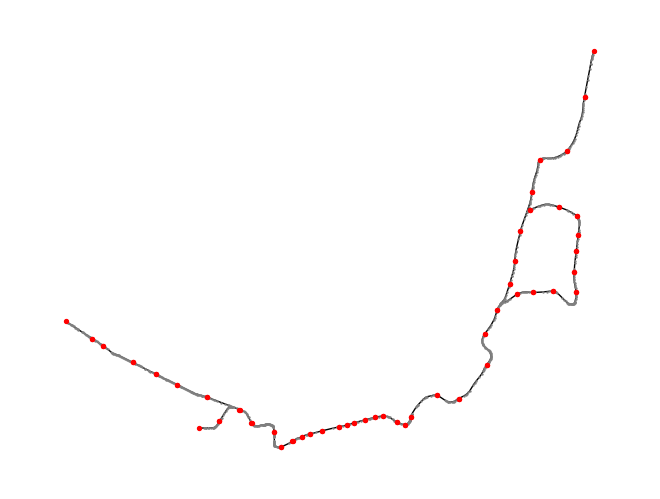

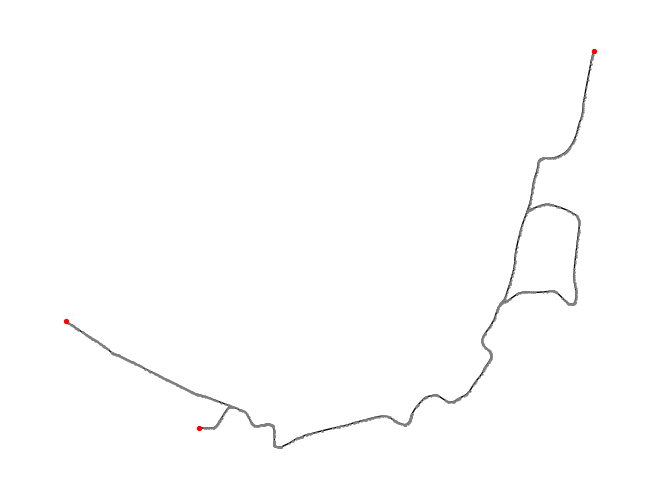

1
Bakerloo


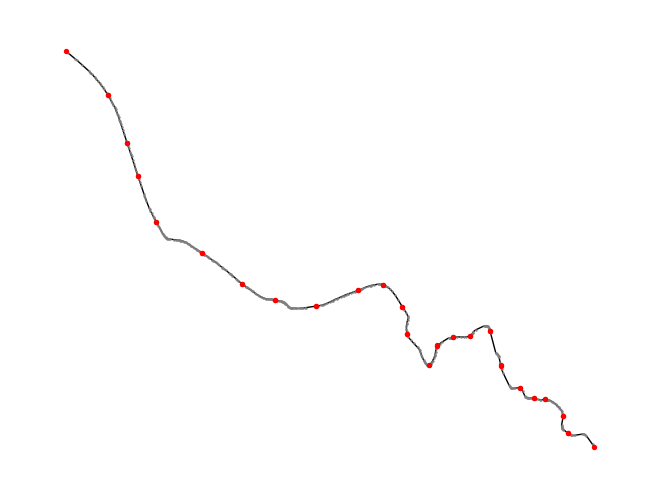

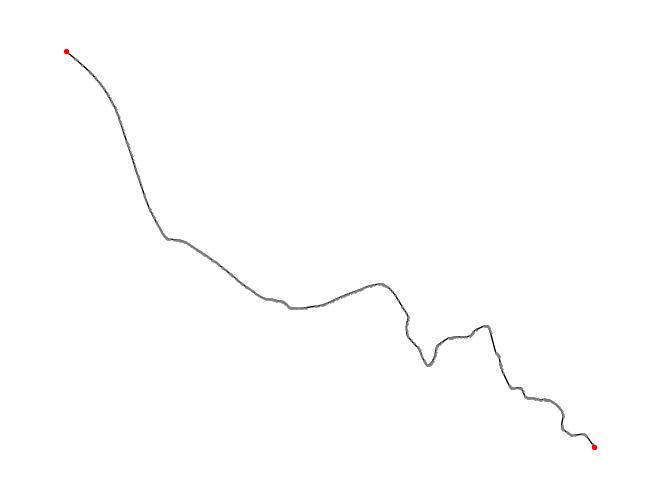

1
Circle


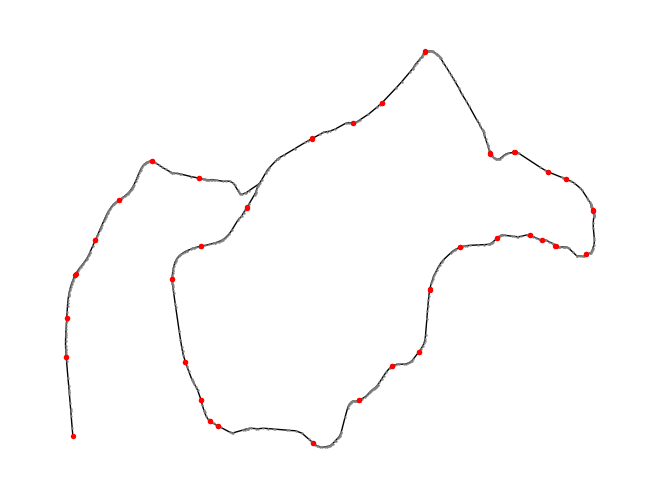

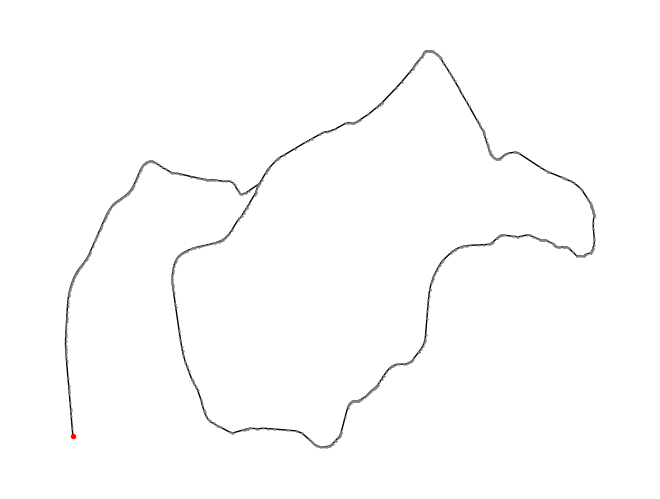

1
Metropolitan


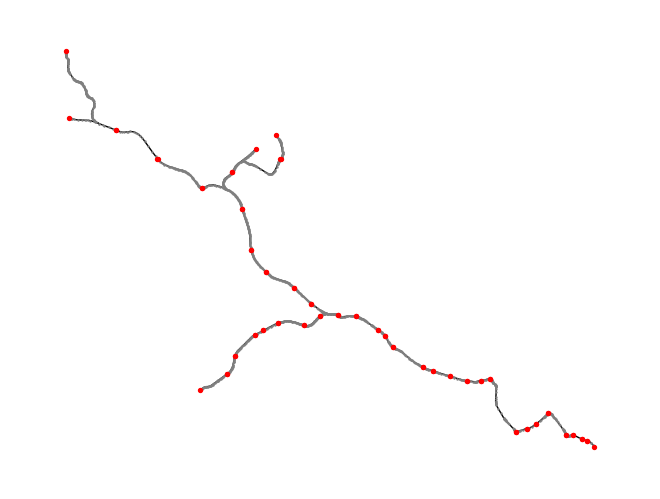

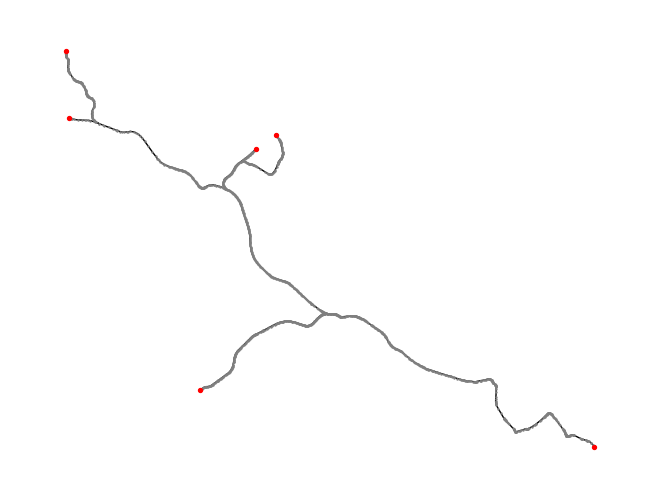

1
District


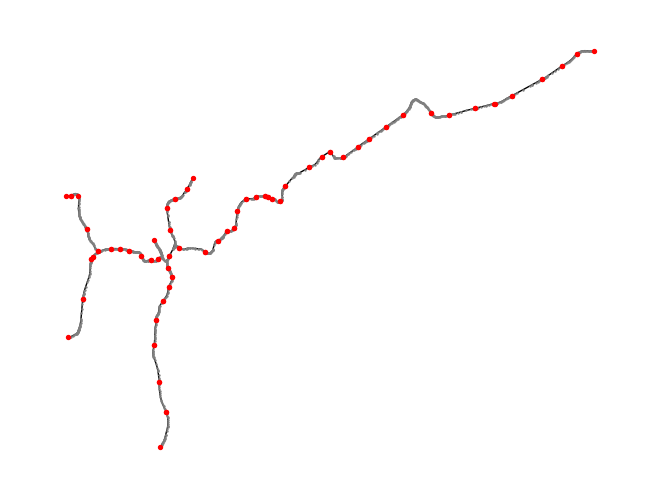

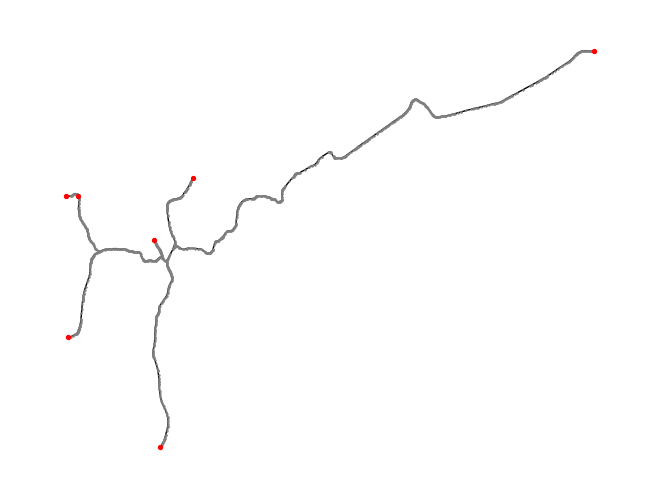

1
Hammersmith & City


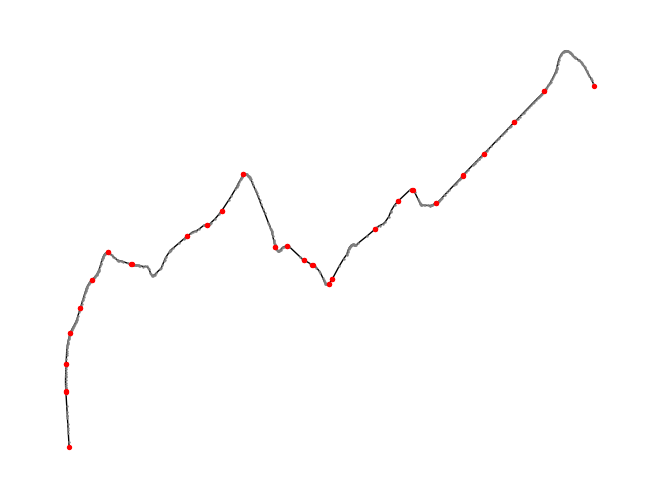

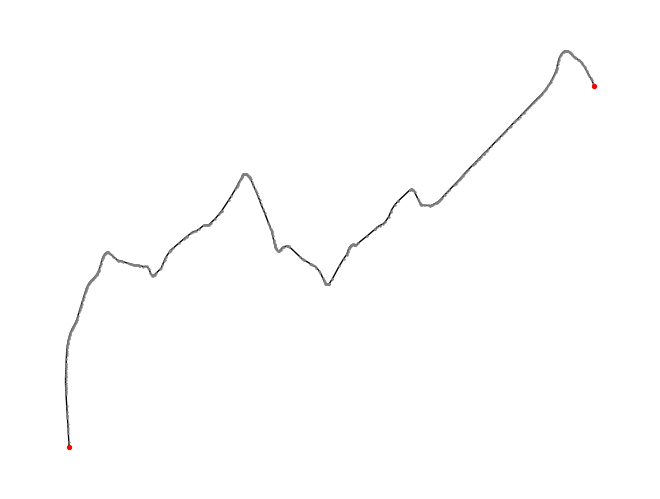

1
Waterloo & City


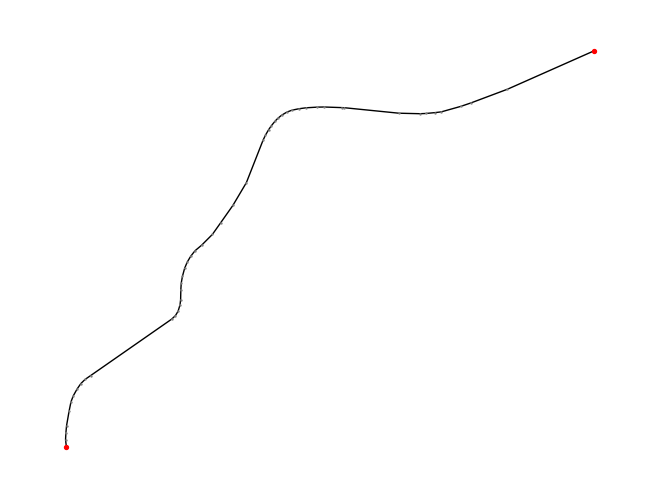

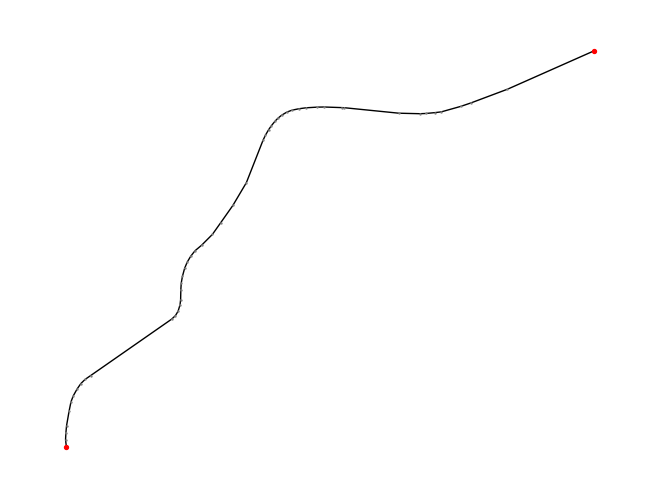

1
Northern


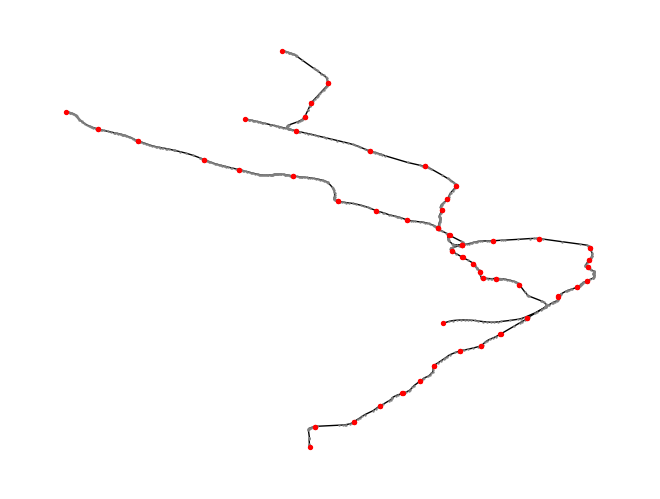

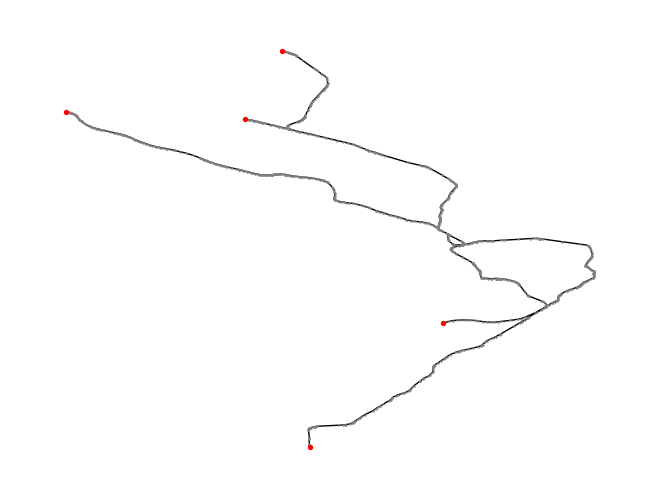

1
DLR


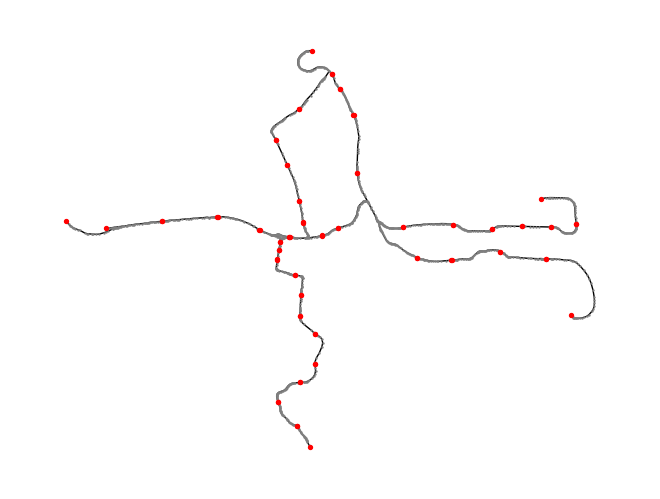

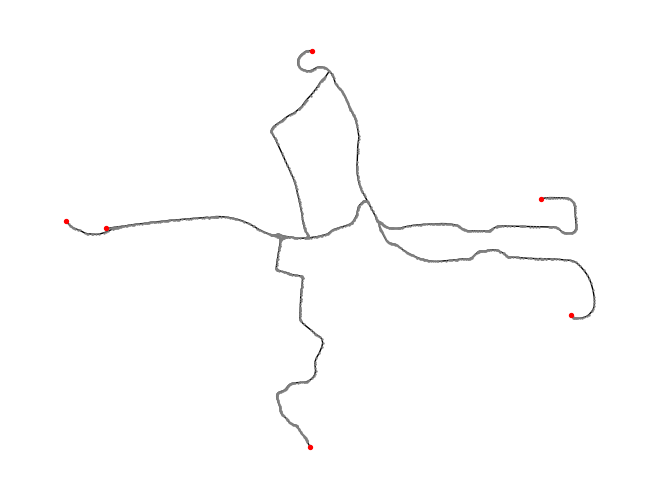

1


In [144]:
#create an empty dict to hold our geometric graphs
geometric_graphs = {}

#iterate through each line individually
for line_name in line_names:
    #skip lines that we won't be using
    if line_name in excluded_lines :
        continue
    print(line_name)
    
    #subset our line and station files for the ones the belong to a specific line
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #create empty graph
    G= nx.Graph()
    
    #iterate through our line geometries
    for i, line in temp_lines.iterrows():
        #get list of coordinates that define our line
        _l = list(line.geometry.coords)

        #add coordinates as edges
        G.add_edges_from(list(zip(_l,_l[1:])))
    
    #remove any self loops
    G.remove_edges_from(nx.selfloop_edges(G))
    
    #the position of the node is the name of the node
    #let's extract this to plot our graph
    pos = {n: n for n in G.nodes()}
    
    # get degree one nodes
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    
    #let's plot our graph and all degree one nodes
    nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
    plt.show()
    
    #get distance between all points of 1-degree, this will be a matrix
    dist = distance.cdist(k1, k1)
    
    #add edges between points that are close
    for j in range(dist.shape[0]-1):
        temp = dist[j][j+1:]
        #get index of closest node
        i_min = np.argmin(temp)
        if dist[j][i_min+j+1]<50:
            G.add_edge(k1[j],k1[i_min+j+1])
    
    #recalculate degree
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #plot new graph
    nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
    plt.show()
    print(nx.number_connected_components(G))
    #store graph in dictionary
    geometric_graphs[line_name] = G


In [145]:
#create a dataframe with all geometries from all valid lines
#this list will contain a dictionary for each edge in our graph that contains
# node pairs, line name, and a geometry (this is just for quick visualization purposes and will be replaced by true geometry)
edge_list = []
def _has_ids(k):
    #helper function to check if line contains id of start and end station
    if ('start_sid' in k.keys()) and ('end_sid' in k.keys()):
        return True
    else:
        return False

#iterate through each line seperately 
for line_name in line_names:
    if line_name in excluded_lines :
        continue
        
    #subset lines and stations
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #for each line in our subset dataframe get each origin and destination pair
    for i, line in temp_lines.iterrows():
        for k in json.loads(line.lines):
            if k['name'] == line_name:
                if _has_ids(k):
                    
                    #get start and end station ids
                    start_id = k['start_sid']
                    end_id = k['end_sid']

                    #get info of start and end station
                    start_station = temp_stations[(temp_stations.id == start_id) | (temp_stations.altmodeid == start_id)].values
                    end_station = temp_stations[(temp_stations.id == end_id) | (temp_stations.altmodeid == end_id)].values
                    
                    #if no matching station exist, let's just take the starting and ending coordinate of the line for now
                    if len(start_station) >= 1 and len(end_station) >=1:
                        s_geom = start_station[0][-1].coords[0]
                        e_geom = end_station[0][-1].coords[0]
                        edge_list.append({
                            'line_name': line_name,
                            'start_id': start_id,
                            'end_id': end_id,
                            'geometry': LineString([s_geom, e_geom])
                        })

In [146]:
#turn our dictionary list into a geopandas df to quickly plot and sanity check our work
edge_gdf = gpd.GeoDataFrame(edge_list)
edge_gdf.crs = lines.crs

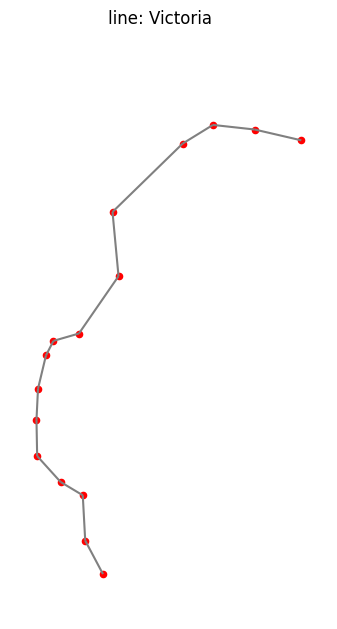

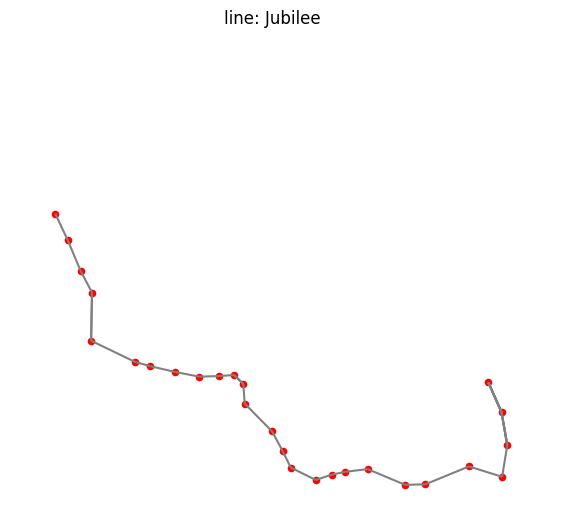

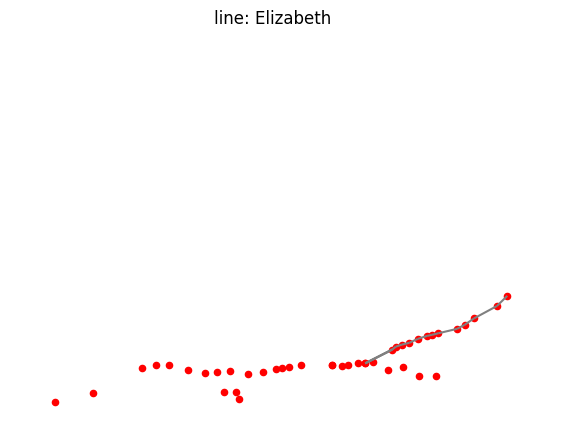

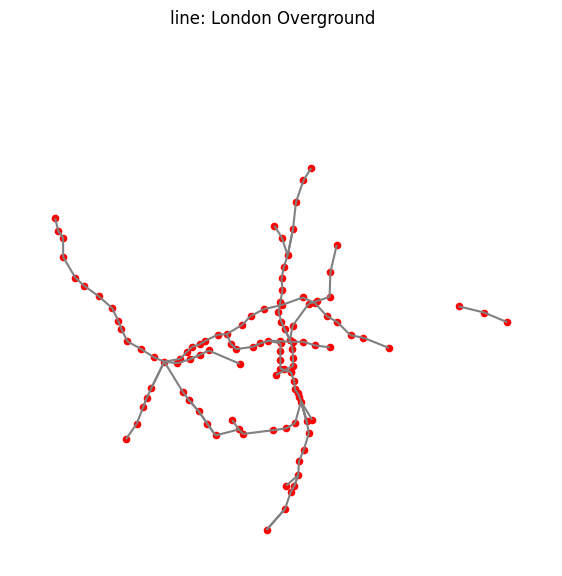

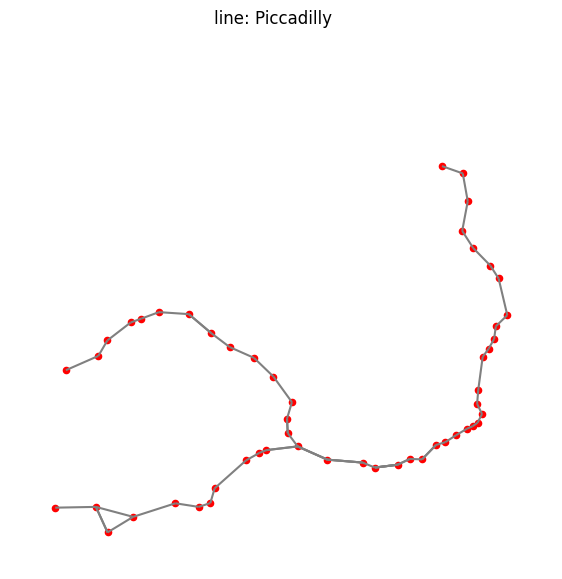

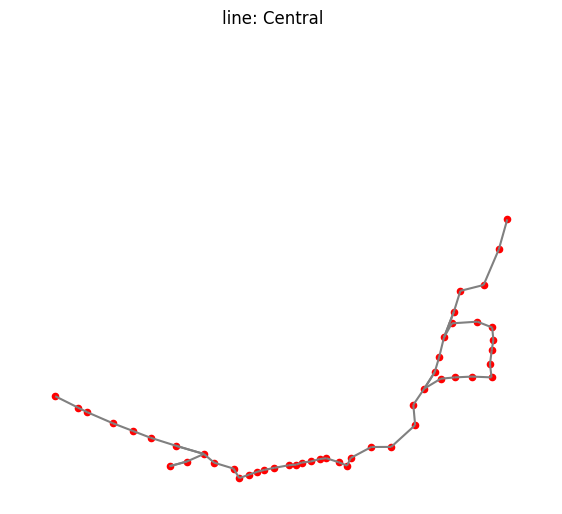

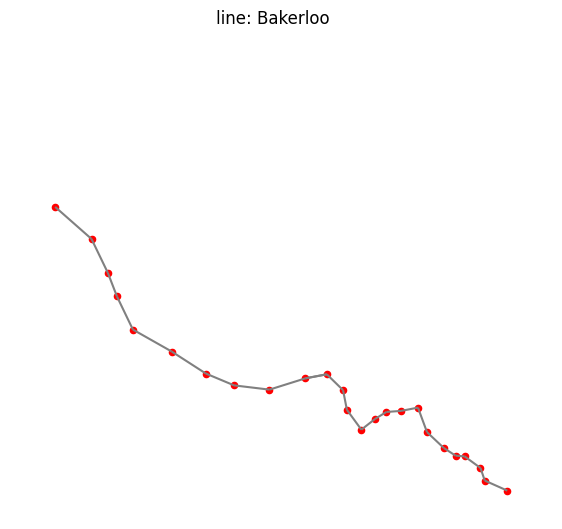

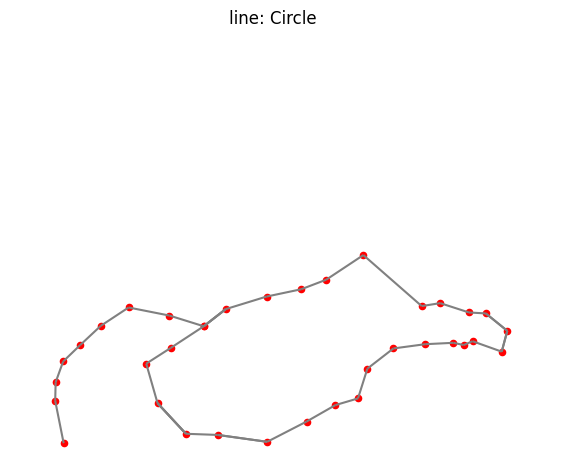

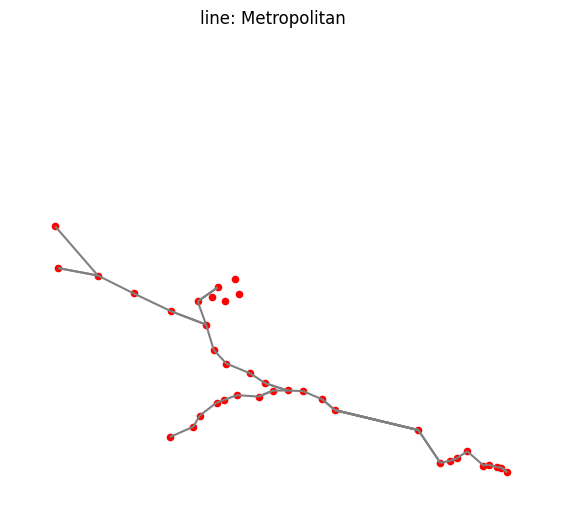

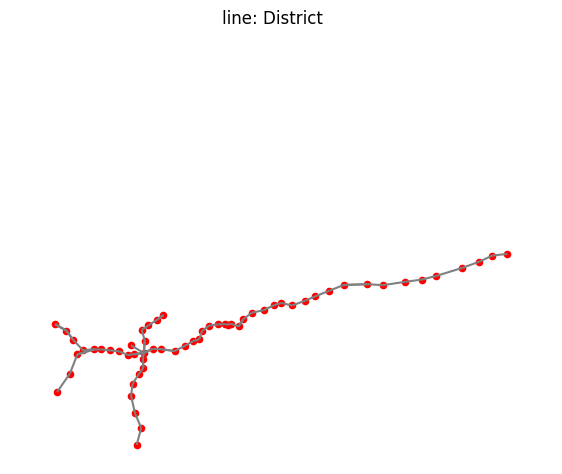

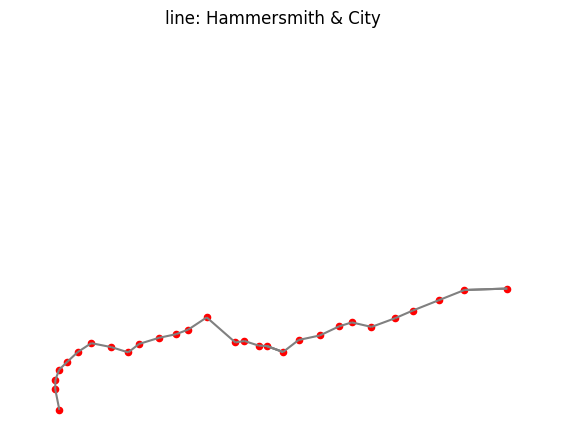

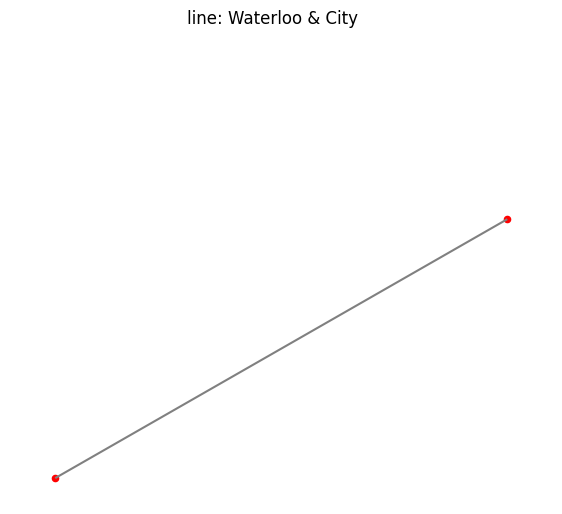

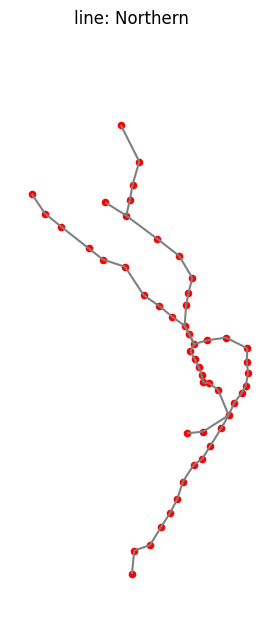

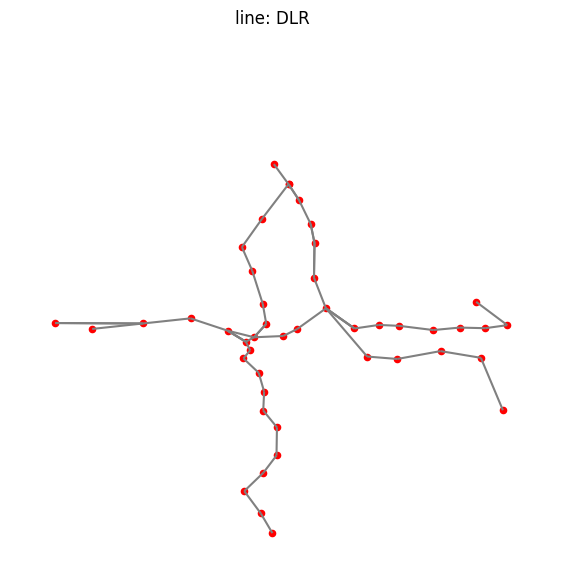

In [148]:
### Add geometry information back into the graph
for line_name in line_names:
    if line_name in excluded_lines :
        continue
    temp_lines = edge_gdf[edge_gdf.line_name == line_name]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #let's plot our lines so we can check them
    fig, ax = plt.subplots(figsize = (7,7))
    fig.suptitle(f'line: {line_name}')
    ax.set_aspect("equal")
    ax.axis('off')
    ax.margins(0.1)
    
    base = temp_lines.plot(ax=ax, color='grey')
    temp_stations.plot(ax=base, markersize=20, color='red')
    plt.show()
    
    #add real geometry back
    for i, edge in temp_lines.iterrows():
        #get start and end of line coordinates
        start = edge.geometry.coords[0]
        end = edge.geometry.coords[-1]
        
        #let's get all the coordinates in our geometric graph
        nodes = list(geometric_graphs[line_name].nodes)
        
        #find nearest node in graph to origin and destination
        s_dist = distance.cdist([start], nodes)[0]
        s_i = np.argmin(s_dist)
        source= nodes[s_i]
        
        t_dist = distance.cdist([end], nodes)[0]
        t_i = np.argmin(t_dist)
        target= nodes[t_i]
        
        #get shortest path
        sp = nx.shortest_path(geometric_graphs[line_name], source, target)
        
        #make into geometry
        #notice how I'm also adding the start and end coordinates to the line definition
        #this fixes the problem of stations and lines not matching up
        geometry = LineString([start] + sp + [end])
        edge_gdf.loc[i, 'geometry'] = geometry

In [149]:
#let's store the length of the real geometry
edge_gdf['length'] = edge_gdf.geometry.length

In [150]:
#let's replace the ids with the actual name
#get all station names
station_names_2 = {row.altmodeid: row['name'] for i, row in stations.iterrows() if row.altmodeid != None}
station_names.update(station_names_2)

In [151]:
edge_gdf['start_id'] = edge_gdf['start_id'].apply(lambda x: station_names[x])
edge_gdf['end_id'] = edge_gdf['end_id'].apply(lambda x: station_names[x])

In [152]:
#now we can use this to create our network!
G = nx.from_pandas_edgelist(edge_gdf, source = 'start_id', target='end_id', edge_attr=['length', 'line_name'])

{'Victoria', 'Jubilee', 'London Overground', 'Elizabeth', 'Piccadilly', 'Central', 'Bakerloo', 'Metropolitan', 'Circle', 'District', 'Hammersmith & City', 'Waterloo & City', 'Northern', 'DLR'}


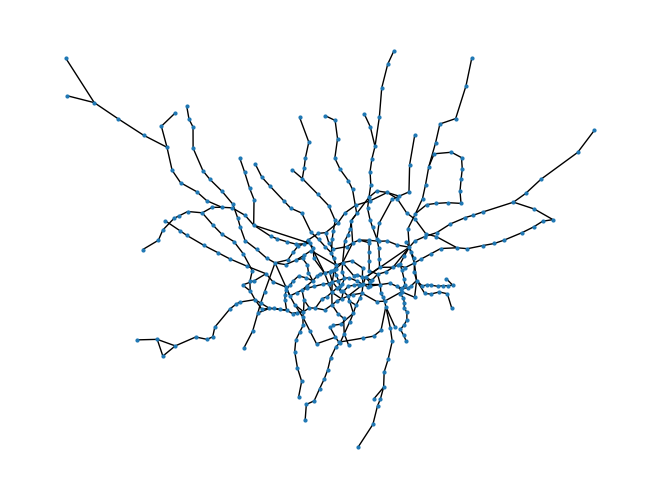

In [153]:
#let's plot
#notice that even though we created the real geometries, the graph still plots just straight line
#this is because networkx doesn't have a concept of a edge geometry
#however this is ok, since we only need the distance as weights, and that is already an attribute in our graph
pos = {row['name']: row.geometry.coords[0] for i, row in stations.iterrows() if row['name'] in G.nodes()}
Gcc = nx.connected_components(G)
for n in Gcc:
    G_sub = G.subgraph(n)
    lines = [data['line_name'] for u,v, data in G_sub.edges(data=True)]
    print(set(lines))
    nx.draw(G_sub, pos, node_size=4)
    plt.show()

In [154]:
#save position to graph
nx.set_node_attributes(G, pos, 'coords')

### Sanity check our network

In [155]:
#check that all distances are greater or equal to euclidean distance
for u,v, data in G.edges(data=True):
    assert(data['length'] >= distance.euclidean(pos[u], pos[v]))

In [156]:
#We can also check the degree of the nodes in our network and check that they make sense
deg_london = nx.degree(G)

In [157]:
df = pd.DataFrame(index = dict(deg_london).keys())
df['degree'] = dict(deg_london).values()

In [158]:
df.sort_values('degree', ascending =False).head(20)

,degree
Stratford,9
Bank and Monument,8
Baker Street,7
King's Cross St. Pancras,7
West Ham,6
Canning Town,6
Earl's Court,6
Liverpool Street,6
Oxford Circus,6
Green Park,6


### Merge Network with OD data

ok, we are almost done!

We have processed our raw data, now we need to combine the two (TLF OD and our Network). For this we need two types of merge:

1. add flows as weights to the network (to be able to calculate disruptions to the network)
2. create OD with distance for our spatial interaction models (for our spatial interaction models)

In [159]:
#check that our OD data and network data match
OD_names = set(london_OD.station_origin.unique())
network_names = set([n for n in G.nodes()])

In [160]:
network_names.symmetric_difference(OD_names)

{'Abbey Wood',
 'Acton Main Line',
 'Albany Park',
 'Alexandra Palace',
 'Banstead',
 'Barking Riverside',
 'Barnehurst',
 'Barnes',
 'Barnes Bridge',
 'Battersea Park',
 'Bayford',
 'Beckenham Hill',
 'Beckenham Junction',
 'Bellingham',
 'Belmont',
 'Belvedere',
 'Berrylands',
 'Bexley',
 'Bexleyheath',
 'Bickley',
 'Birkbeck',
 'Blackheath',
 'Bowes Park',
 'Brentford',
 'Brimsdown',
 'Bromley North',
 'Bromley South',
 'Brookmans Park',
 'Broxbourne',
 'Burnham',
 'Canary Wharf EL',
 'Carshalton',
 'Carshalton Beeches',
 'Castle Bar Park',
 'Caterham',
 'Catford',
 'Catford Bridge',
 'Chafford Hundred',
 'Charlton',
 'Cheam',
 'Chelsfield',
 'Chessington North',
 'Chessington South',
 'Chipstead',
 'Chislehurst',
 'Chiswick',
 'City Thameslink',
 'Clock House',
 'Coulsdon South',
 'Coulsdon Town',
 'Crayford',
 'Crews Hill',
 'Cricklewood',
 'Crofton Park',
 'Cuffley',
 'Custom House EL',
 'Dagenham Dock',
 'Dartford',
 'Deptford',
 'Drayton Green',
 'Drayton Park',
 'Earlsfield',


Ok, we have a few stations that don't match up. They are small enough that we can solve this quickly by creating a mapping between names of the stations that we can keep.

* Battersea power station and Nine Elms data doesn't exist in our TFL data because the station wasn't opened when the data was collected. This was an extension of Northern line that opened recently.
* Action Main Line, Hanwell, Hayes & Harlington, Southall, and West Ealing are part of crossrail which we are not considering

In [161]:
name_map = {
    'Heathrow Terminal 4 EL': 'Heathrow Terminal 4',
    'Heathrow Terminals 123': 'Heathrow Terminals 2 & 3',
    'Heathrow Terminals 2 & 3 EL': 'Heathrow Terminals 2 & 3',
    "Walthamstow Queen's Road": 'Walthamstow Queens Road'
}

In [162]:
london_OD.station_origin = london_OD.station_origin.apply(
    lambda x: name_map[x] if x in name_map.keys() else x
)
london_OD.station_destination = london_OD.station_destination.apply(
    lambda x: name_map[x] if x in name_map.keys() else x
)

In [163]:
#let's filter out the stations that we don't have in our network
OD_names = set(london_OD.station_origin.unique())
_filter = list(network_names.symmetric_difference(OD_names))
_filter

['Ladywell',
 'Luton Airport Parkway',
 'Coulsdon Town',
 'Malden Manor',
 'Gordon Hill',
 'Oakleigh Park',
 'Hackbridge',
 'Alexandra Palace',
 'Hertford East',
 'Wallington',
 'Winchmore Hill',
 'Radlett',
 'New Eltham',
 'Riddlesdown',
 'Twickenham',
 'Reedham',
 'Westcombe Park',
 'Waddon',
 'Brentford',
 'Hatfield',
 'Paddington HEX',
 'Harpenden',
 'Rye House',
 'Grove Park',
 'Barnes',
 'Hither Green',
 'Drayton Green',
 'Twyford',
 'Ware',
 'Burnham',
 'Northumberland Park',
 'Purley',
 'Enfield Lock',
 'Surbiton',
 'Deptford',
 'Kew Bridge',
 'Fenchurch Street',
 'East Dulwich',
 'Teddington',
 'Elmers End',
 'Iver',
 'Hampton Wick',
 'North Dulwich',
 'South Greenford',
 'Tulse Hill',
 'Grange Park',
 'Kingswood',
 'Castle Bar Park',
 'Heathrow Terminal 5 EL',
 'Kenley',
 'Woolwich Dockyard',
 'North Sheen',
 'Norbury',
 'Fulwell',
 'Carshalton Beeches',
 'Sanderstead',
 'Ewell West',
 'Belmont',
 'Maidenhead',
 'Welling',
 'West Wickham',
 'Eden Park',
 'New Barnet',
 'Upper

In [164]:
london_OD = london_OD[~london_OD.station_origin.isin(_filter)]
london_OD = london_OD[~london_OD.station_destination.isin(_filter)]

**Add flow data to our network**

Our TFL data contains flows for OD pairs, but we don't know the flows passing through each edge in our network. We will have to calculate this assuming fall people travelling from Origin to Destination station are taking the shortest path within the network.

In [165]:
#create a dictionary to store flows for all edges
flows = {(u,v): 0 for u,v in G.edges()}

In [166]:
#calculate shortest paths for all flows and add data to dict
for i, row in london_OD.iterrows():
    source = row.station_origin
    target = row.station_destination
    
    #get shortest path
    path = nx.dijkstra_path(G, source, target)
    
    #our path is a list of nodes, we need to turn this to a list of edges
    path_edges = list(zip(path,path[1:])) 
    
    #add flows to our dict
    for u,v in path_edges:
        try:
            flows[(u,v)] += row.flows
        except:
            flows[(v,u)] += row.flows

In [167]:
#set this as a network attribute
nx.set_edge_attributes(G, flows, 'flows')

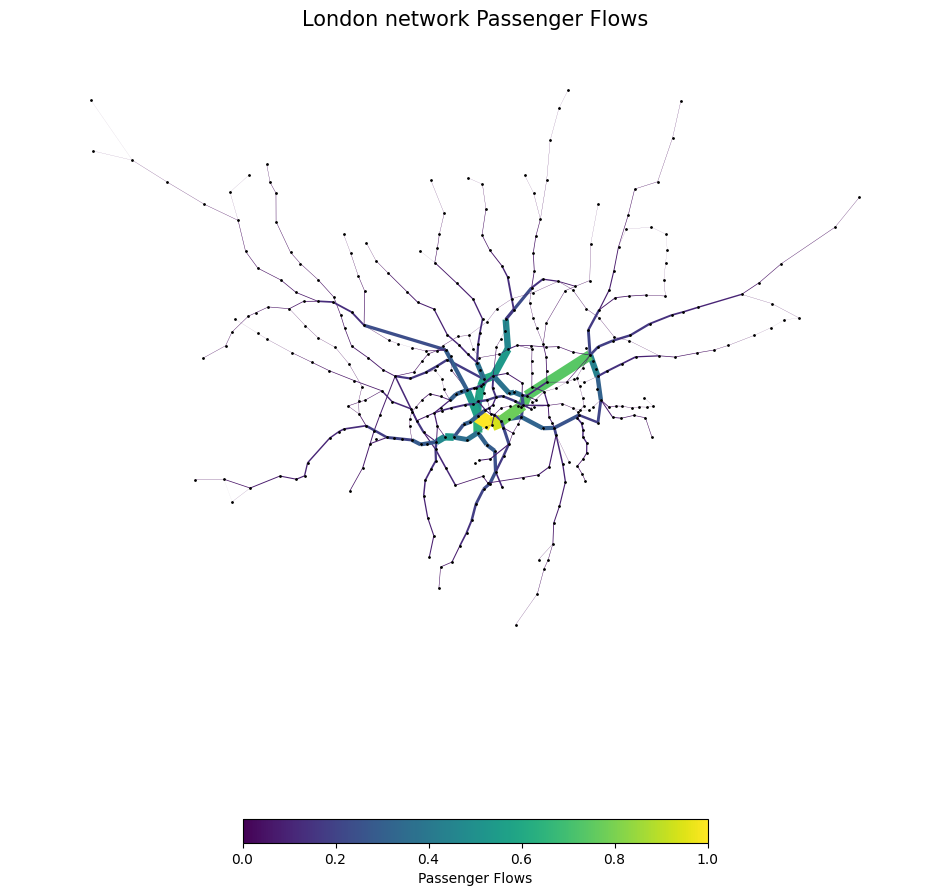

In [168]:
#plot our calcuated flows
flows_values = flows.values()
flow_color=[(i[2]['flows']/max(flows_values)) for i in G.edges(data=True)]
flow_width=[(i[2]['flows']/max(flows_values)*10) for i in G.edges(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

#pos=nx.spring_layout(X)
edg=nx.draw_networkx_edges(G, pos,edge_color=flow_color, width=flow_width)

nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.colorbar(edg,label="Passenger Flows",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London network Passenger Flows",fontsize=15)
plt.show()

In [169]:
#get edge with highest number of flows
max(flows, key=flows.get)

('Green Park', 'Westminster')

What is going on here? Should we fix it or should we just consider it as a limitation of our model?

In [170]:
#get edge data with lowest number of flows
min(flows, key=flows.get)

('Wandsworth Road', 'Battersea Park')

In [172]:
#save graph
for i in G.nodes():
    G.nodes[i]['coords'] = str(G.nodes[i]['coords'])
nx.write_graphml_lxml(G, "data/cleaned/london_updated.graph")

### Data Exploration

In [174]:
#node attributes
print("Node attributes:")
for node, data in G.nodes(data=True):
    print(f"Node {node}: {data}")

#edge attributes
print("\nEdge attributes:")
for u, v, data in G.edges(data=True):
    print(f"Edge ({u}, {v}): {data}")

Node attributes:
Node Brixton: {'coords': '(531054.1492209797, 175421.9307214191)'}
Node Stockwell: {'coords': '(530496.8577275898, 176472.9299082592)'}
Node Vauxhall: {'coords': '(530420.2721309648, 177894.3861118151)'}
Node Pimlico: {'coords': '(529723.5711402855, 178312.66108136834)'}
Node Victoria: {'coords': '(528989.1607059089, 179124.96302728722)'}
Node Green Park: {'coords': '(528968.085643932, 180259.31506057666)'}
Node Oxford Circus: {'coords': '(529015.4430721067, 181234.2241558549)'}
Node Warren Street: {'coords': '(529265.1940102909, 182280.51328083948)'}
Node Euston: {'coords': '(529500.4001957492, 182738.58533655445)'}
Node King's Cross St. Pancras: {'coords': '(530299.5672470357, 182969.18209262053)'}
Node Highbury & Islington: {'coords': '(531541.7216167527, 184768.32345669725)'}
Node Finsbury Park: {'coords': '(531353.3782590172, 186783.54791950254)'}
Node Seven Sisters: {'coords': '(533554.9105144802, 188928.8231568151)'}
Node Tottenham Hale: {'coords': '(534503.7382

# Centrality Measures
- Use degree, betweenness and closeness (topological)

In [175]:
G1 = nx.Graph(G)

##### Degree Centrality (Measure 1):

In [176]:
#  We can calculate the degree centrality using networkx function:
deg_london =nx.degree_centrality(G)
nx.set_node_attributes(G,dict(deg_london),'degree')

In [177]:
# To dataframe using the nodes as the index
df = pd.DataFrame()
df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df.set_index('station_name', inplace=True)  # Set 'station_name' as the index
df['degree'] = pd.Series(nx.get_node_attributes(G, 'degree'))

df.reset_index(inplace=True)
df_sorted = df.sort_values(["degree"], ascending=False)
df_sorted[0:15]

,station_name,degree
21,Stratford,0.0225
227,Bank and Monument,0.0200
33,Baker Street,0.0175
9,King's Cross St. Pancras,0.0175
22,West Ham,0.0150
23,Canning Town,0.0150
157,Earl's Court,0.0150
42,Liverpool Street,0.0150
6,Oxford Circus,0.0150
5,Green Park,0.0150


##### Betweeness Centrality (Measure 2):

In [178]:
### Topological betweenness centrality:

#Let us compute the betweenness centrality for the network, without using weights:
bet_london_t=nx.betweenness_centrality(G, normalized=False)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G,bet_london_t,'betweenness_t')

# To dataframe using the nodes as the index
df = pd.DataFrame()
df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df.set_index('station_name', inplace=True)  # Set 'station_name' as the index
df['betweenness_t'] = pd.Series(nx.get_node_attributes(G, 'betweenness_t'))

df.reset_index(inplace=True)
df_sorted = df.sort_values(["betweenness_t"], ascending=False)
df_sorted[0:15]

,station_name,betweenness_t
21,Stratford,23768.093434
227,Bank and Monument,23181.058947
42,Liverpool Street,21610.387049
9,King's Cross St. Pancras,20373.521465
30,Waterloo,19464.882323
5,Green Park,17223.622114
8,Euston,16624.275469
31,Westminster,16226.155916
33,Baker Street,15287.107612
36,Finchley Road,13173.758009


##### Closeness Centrality (Measure 3):

In [179]:
#topological closeness centrality
clos_t=nx.closeness_centrality(G)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G,clos_t,'closeness_t')

# To ataframe using the nodes as the index
df = pd.DataFrame()
df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df.set_index('station_name', inplace=True)  # Set 'station_name' as the index
df['closeness_t'] = pd.Series(nx.get_node_attributes(G, 'closeness_t'))

df.reset_index(inplace=True)
df_sorted = df.sort_values(["closeness_t"], ascending=False)
df_sorted[0:15]

,station_name,closeness_t
5,Green Park,0.114778
227,Bank and Monument,0.113572
9,King's Cross St. Pancras,0.113443
31,Westminster,0.112549
30,Waterloo,0.112265
6,Oxford Circus,0.111204
32,Bond Street,0.110988
272,Farringdon,0.110742
333,Angel,0.110742
274,Moorgate,0.110314


**Part 2: II.1: Centrality Measures**
- Use betweenness (weighted)

In [180]:
G7 = nx.Graph(G)

In [181]:
### Weighted betweenness centrality:
#Let us compute the betweenness centrality for the network, considering the distance between stations:

bet_london_w=nx.betweenness_centrality(G7,weight='length',normalized=False)

# We can add these values to the nodes attributes:
nx.set_node_attributes(G7,bet_london_w,'betweenness_w')

In [182]:
# To dataframe using the nodes as the index
df = pd.DataFrame()
df['station_name'] = pd.Series(nx.get_node_attributes(G7, 'station_name'))
df.set_index('station_name', inplace=True)  # Set 'station_name' as the index
df['betweenness_w'] = pd.Series(nx.get_node_attributes(G7, 'betweenness_w'))

df.reset_index(inplace=True)
df_sorted = df.sort_values(["betweenness_w"], ascending=False)
df_sorted[0:10]

,station_name,betweenness_w
227,Bank and Monument,17588.0
9,King's Cross St. Pancras,16717.0
21,Stratford,14562.0
33,Baker Street,13180.0
6,Oxford Circus,12573.0
8,Euston,12345.0
109,Whitechapel,12267.0
228,Mile End,12108.0
157,Earl's Court,11415.0
110,Shadwell,11127.0
